In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline

from pprint import pprint
from zen_garden.postprocess.results import Results

### Working with results of a ZenGarden run

This notebook shows some examples on how to handle the results of a `zen-garden` run. It uses the outputs of the tests as examples. Therefore, you need to run the tests via 
```
coverage run --source="zen_garden" -m pytest -v tests/testcases/run_test.py
```
to get the data.

### Reading in the results

The results can be read in using the `Results` class. This will automatically read in all relevant files, independent of the number of scenarios or if the optimization was run with perfect or myopic foresight. However, you should know what type of input you are reading in, as the output of some routines will depend on the type.

In [2]:
# This has no scenarios and perfect foresight
res_basic = Results("../outputs/test_1a/")
# Here we have three different scenarios
res_scenario = Results("../outputs/test_6a/")
# This was run with myopic foresight
res_mf = Results("../outputs/test_4g/")
# This was run with aggregated time steps and multi year
res_ts = Results("../outputs/test_4f/")

### Accessing the config

The standard dictionaries, i.e. system, analysis, scenarios, solver and dict_sequence_time_steps can be accessed via the results dict.

In [5]:
# Show the analysis settings
pprint(res_basic.results["analysis"])

{'dataset': 'C:\\Users\\Lukas '
            'Kunz\\ETH\\ZEN_garden\\ZEN-garden\\tests\\testcases\\test_1a',
 'discount_rate': 0.06,
 'earliest_year_of_data': 1900,
 'folder_name_system_specification': 'system_specification',
 'folder_output': 'C:\\Users\\Lukas Kunz\\ETH\\ZEN_garden\\ZEN-garden\\outputs',
 'header_data_inputs': {'set_capacity_types': 'capacity_type',
                        'set_carriers': 'carrier',
                        'set_conditioning_carrier_parents': 'carrier',
                        'set_conditioning_carriers': 'carrier',
                        'set_conversion_technologies': 'technology',
                        'set_dependent_carriers': 'carrier',
                        'set_edges': 'edge',
                        'set_elements': 'element',
                        'set_existing_technologies': 'existing_technology',
                        'set_input_carriers': 'carrier',
                        'set_location': 'location',
                        'set_nodes

### Extracting individual data frames

You can access individual data frames from any component with the `get_df` method. However, the behavior differs slightly for the usecases.
If the optimization was run with perfect foresight and no scenarios, then the data frame is returned as `pandas.Series`. For myopic foresight, the final dataframe is stiched together from the relevant outputs if the component is set yearly. If multiple scenarios were run, a dictionary containing the data frame for all different scenarios is returned. However, you can specify the scenario in advance, then only a single data frame is returned.

Additionally, the method provides a shortcut to save the extracted dataframe directly to a CSV, or in case of different scenarios to a bundle of CSV files.

In [5]:
# This will return a single data frame
df = res_basic.get_df('export_carrier_flow')
df

carrier      node  time_operation
natural_gas  CH    0                 0.0
             DE    0                 0.0
heat         CH    0                 0.0
             DE    0                 0.0
Name: export_carrier_flow, dtype: float64

In [5]:
# you can also save the dataframe directly to a csv:
df = res_basic.get_df('carbon_emissions_overshoot', to_csv="test")
# this prints out the content of the generated csv
!cat test.csv

'cat' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
# if we have multiple scenarios, all dataframe will be returned in a dict
df_dict = res_scenario.get_df('export_carrier_flow')
pprint(df_dict)

{'scenario_': carrier      node  time_operation
natural_gas  CH    0                 0.0
                   1                 0.0
                   2                 0.0
                   3                 0.0
             DE    0                 0.0
                   1                 0.0
                   2                 0.0
                   3                 0.0
heat         CH    0                 0.0
                   1                 0.0
                   2                 0.0
                   3                 0.0
             DE    0                 0.0
                   1                 0.0
                   2                 0.0
                   3                 0.0
Name: export_carrier_flow, dtype: float64,
 'scenario_1': carrier      node  time_operation
natural_gas  CH    0                 0.0
                   1                 0.0
                   2                 0.0
                   3                 0.0
             DE    0                 0.0

In [8]:
# saving this to a csv will create a file for each scenario
df_dict = res_scenario.get_df('export_carrier_flow', to_csv="test2")
# list files and print content of one
!echo "Generated files: "
!ls test2*
!echo 
!echo "Output of test2_scenario_2.csv"
!cat test2_scenario_2.csv

"Generated files: "


'ls' is not recognized as an internal or external command,
operable program or batch file.


ECHO is on.
"Output of test2_scenario_2.csv"


'cat' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
# we can also specify a specific scneario
df = res_scenario.get_df('export_carrier_flow', scenario="scenario_2")
df

carrier      node  time_operation
natural_gas  CH    0                 0.0
                   1                 0.0
                   2                 0.0
                   3                 0.0
             DE    0                 0.0
                   1                 0.0
                   2                 0.0
                   3                 0.0
heat         CH    0                 0.0
                   1                 0.0
                   2                 0.0
                   3                 0.0
             DE    0                 0.0
                   1                 0.0
                   2                 0.0
                   3                 0.0
Name: export_carrier_flow, dtype: float64

In [10]:
# This will collect the values from the results folders of the different myopic foresight runs
df = res_mf.get_df("carbon_emissions_cumulative")
df

year
0    151.293355
1    302.586710
2    453.880065
Name: carbon_emissions_cumulative, dtype: float64

### Helper functions

The `Results` class implements some helper functions. The function `get_total` allows you to calculate the total Value of a component, for a given year, element and scenario if desired. And the function `get_full_ts` calculates the full (disaggregate) time series for a given component.

In [11]:
# We read out a normal dataframe
df = res_mf.get_df("input_flow")
print(df)

technology          carrier      node  time_operation
natural_gas_boiler  natural_gas  CH    0                  24.988534
                                       1                  24.988534
                                       2                  24.988534
                                       3                   1.387667
                                       4                   1.387667
                                       5                   1.387667
                                       6                  14.087952
                                       7                  14.087952
                                       8                  14.087952
                                       9                   7.271653
                                       10                  7.271653
                                       11                  7.271653
                                       12                 32.309980
                                       13                 32.3

In [12]:
# We can calculate the total value of the dataframe
res_mf.get_total(df)

0              1  \
technology         carrier     node                                 
natural_gas_boiler natural_gas CH    110402.790806  110402.790806   
                               DE    646063.984500  646063.984500   

                                                 2  
technology         carrier     node                 
natural_gas_boiler natural_gas CH    110402.790806  
                               DE    646063.984500

In [13]:
# and also get the full timeseries (disaggregate) if we want
df_disaggregate = res_mf.get_full_ts(df)
df_disaggregate

0           1           2      \
technology         carrier     node                                       
natural_gas_boiler natural_gas CH     21.412454   21.412454   21.412454   
                               DE    117.167515  117.167515  117.167515   

                                          3           4           5      \
technology         carrier     node                                       
natural_gas_boiler natural_gas CH     24.988534   32.309980   32.309980   
                               DE    136.940604  186.758318  186.758318   

                                          6           7           8      \
technology         carrier     node                                       
natural_gas_boiler natural_gas CH     32.309980   32.309980   32.309980   
                               DE    186.758318  186.758318  186.758318   

                                          9      ...       26270       26271  \
technology         carrier     node              ...                           
natural_gas_boiler natural_gas CH     32.309980  ...   32.309980   32.309980   
                               DE    186.758318  ...  186.758318  186.758318   

                                          26272       26273       26274  \
technology         carrier     node                                       
natural_gas_boiler natural_gas CH     32.309980   32.309980   32.309980   
                               DE    186.758318  186.758318  186.758318   

                                          26275       26276       26277  \
technology         carrier     node                                       
natural_gas_boiler natural_gas CH     32.309980   32.309980   28.497224   
                               DE    186.758318  186.758318  159.883478   

                                          26278       26279  
technology         carrier     node                          
natural_gas_boiler natural_gas CH     21.412454   21.412454  
                               DE    117.167515  117.167515  

[2 rows x 26280 columns]

### How to plot your results

The ```Results``` class offers three different plotting functions explained at https://github.com/RRE-ETH/ZEN-garden/discussions/251

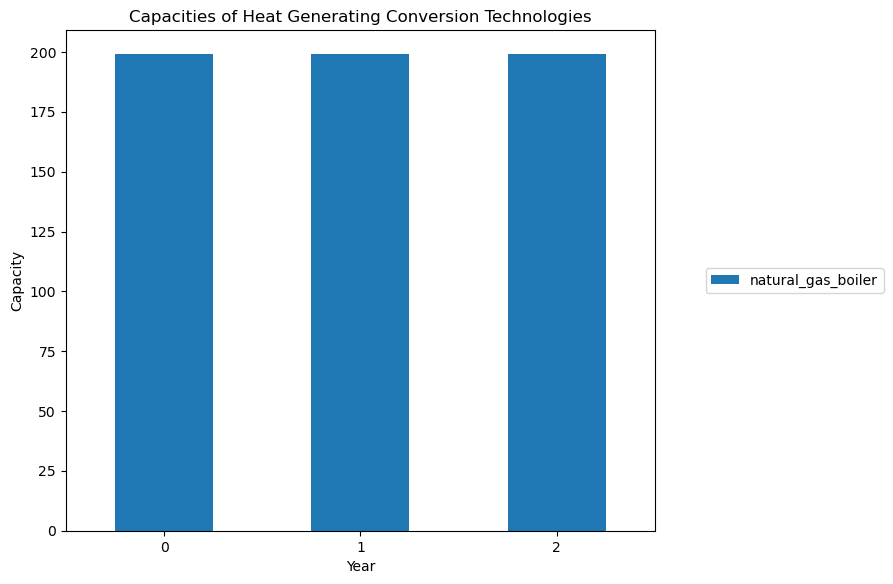

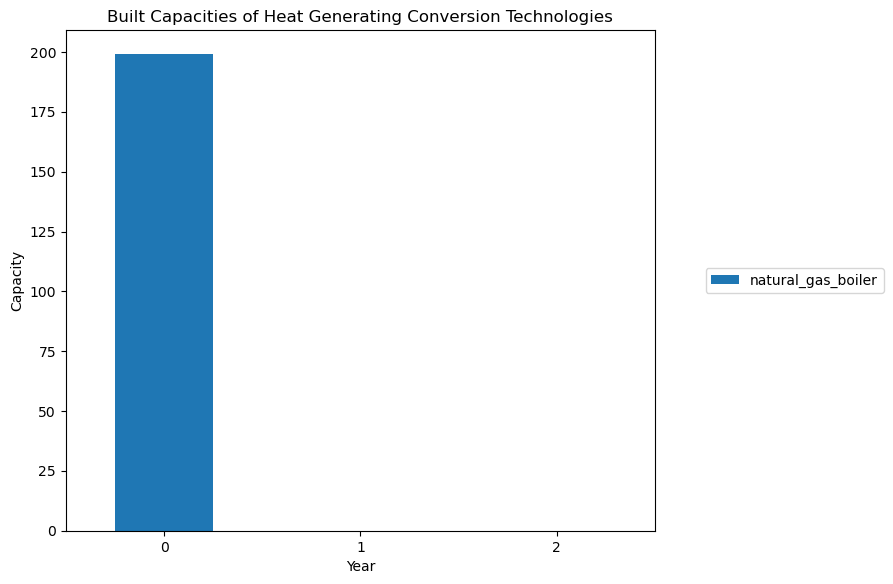

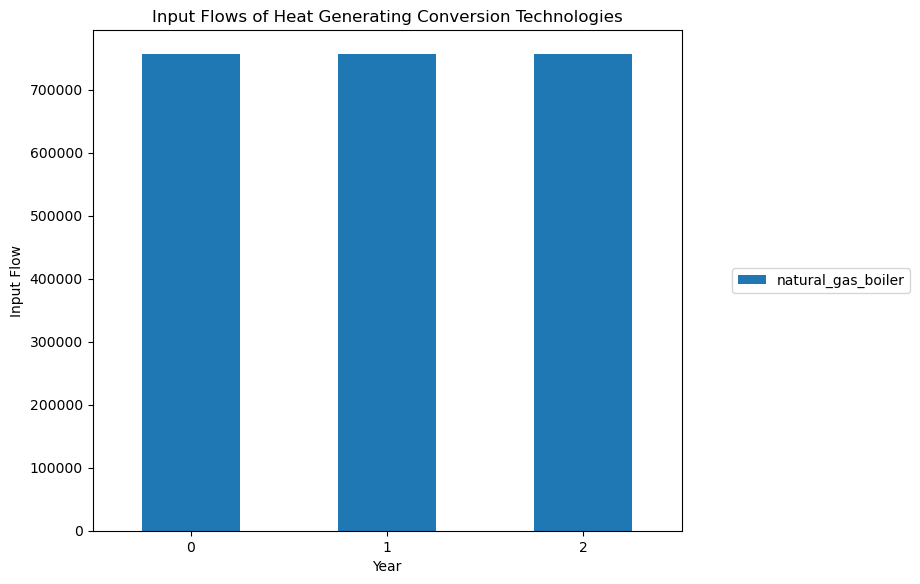

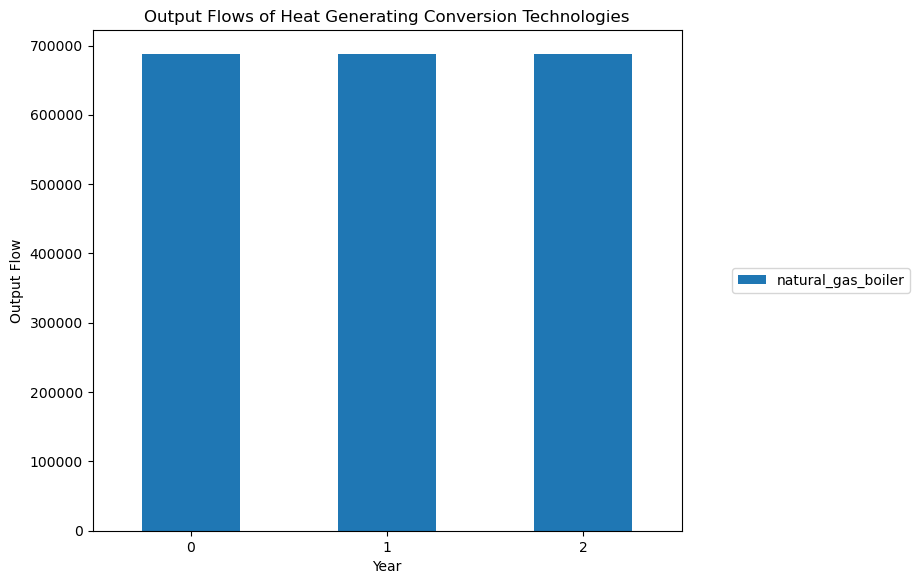

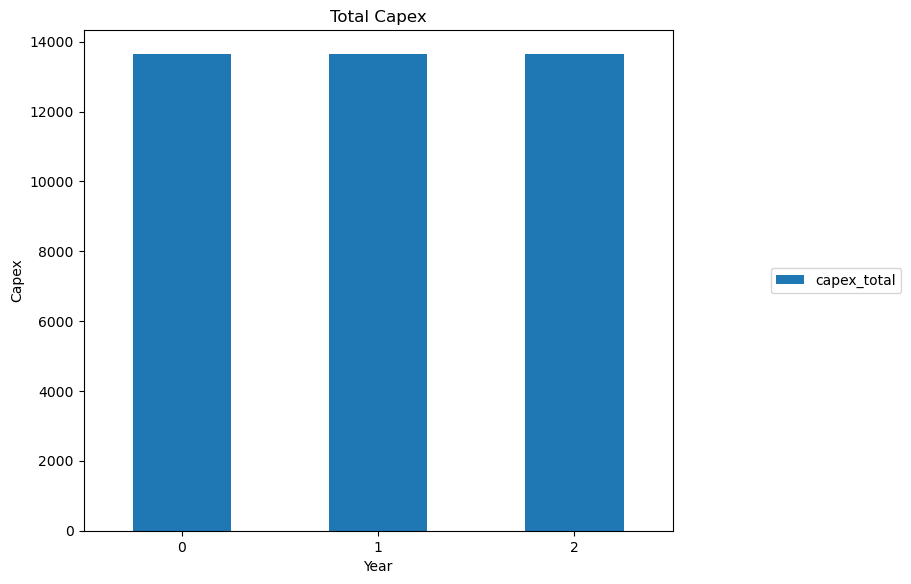

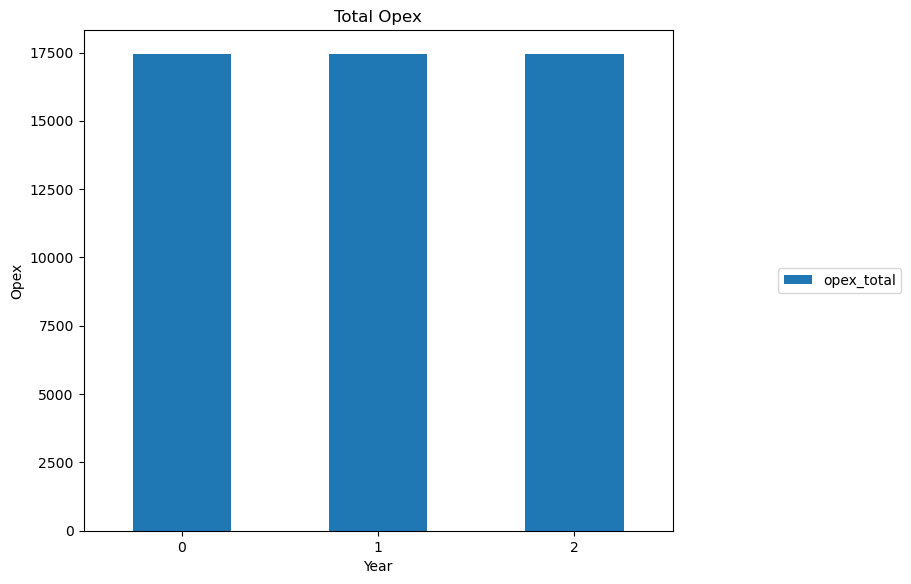

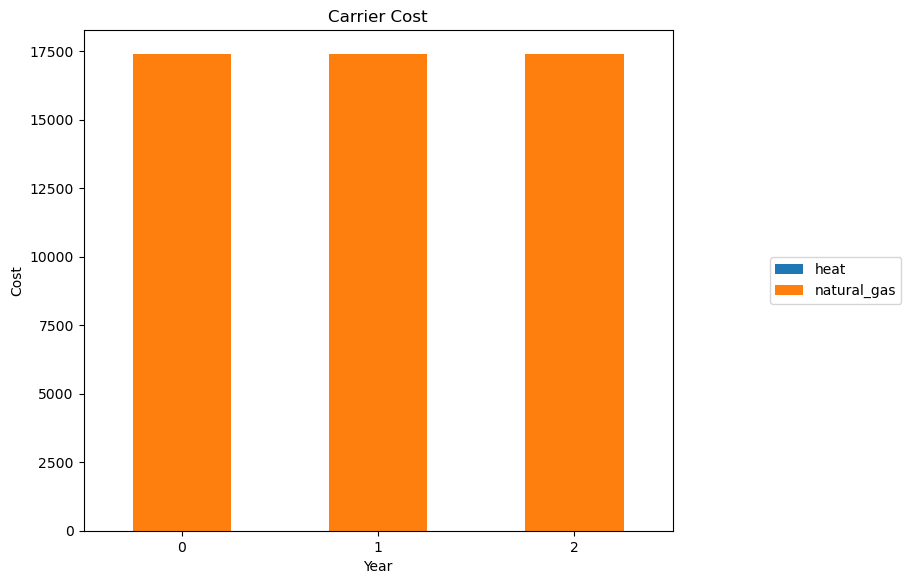

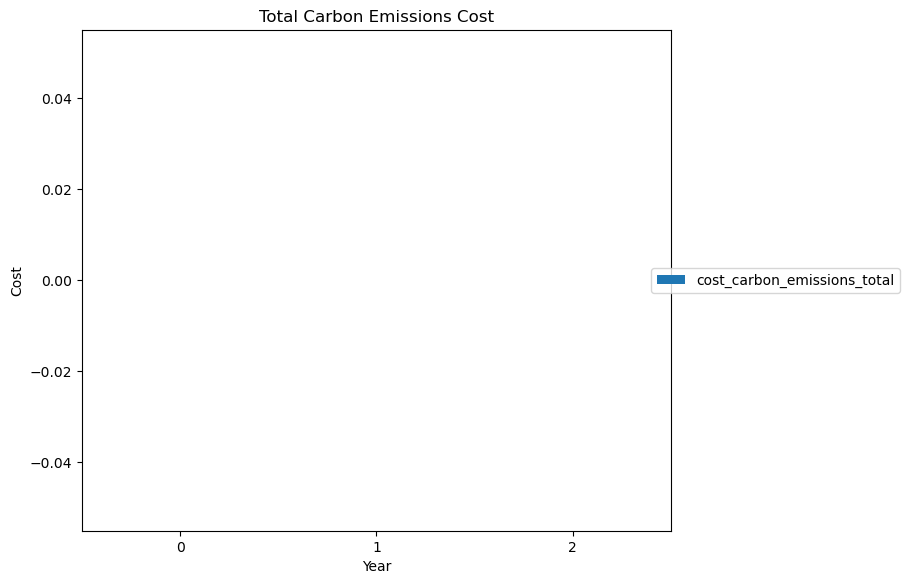

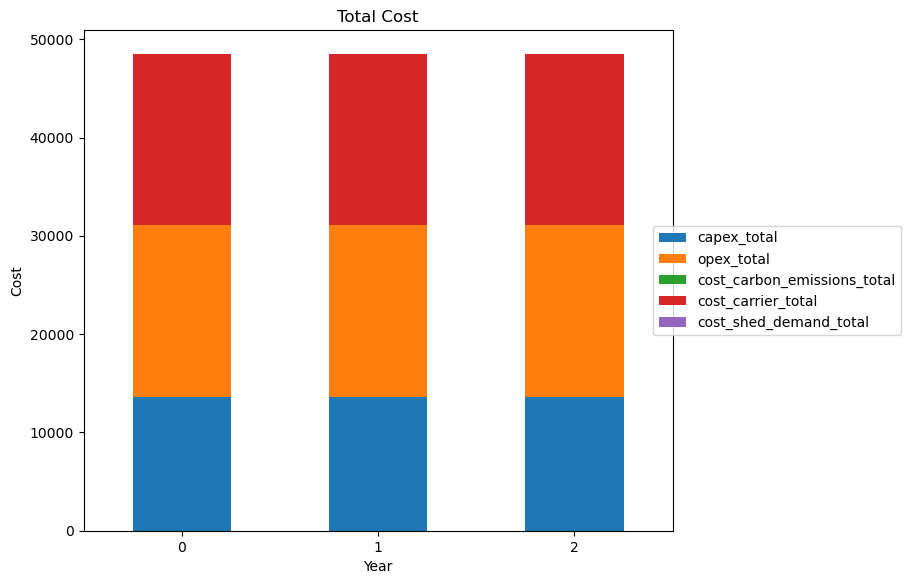

In [3]:
#Create the standard plots of your Results object (e.g. res_ts)
res_ts.standard_plots()

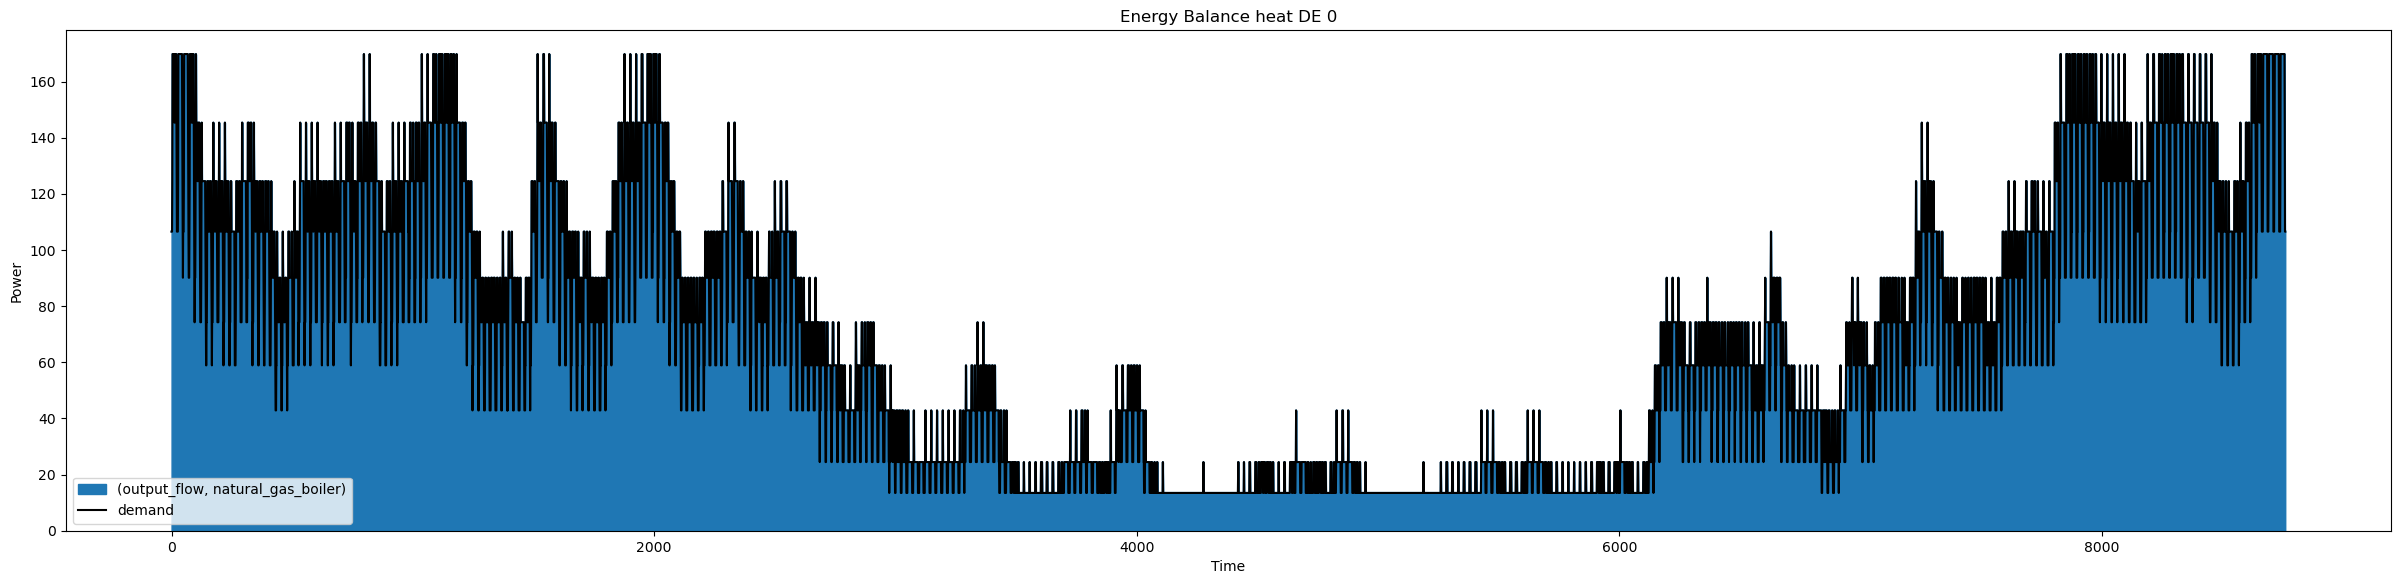

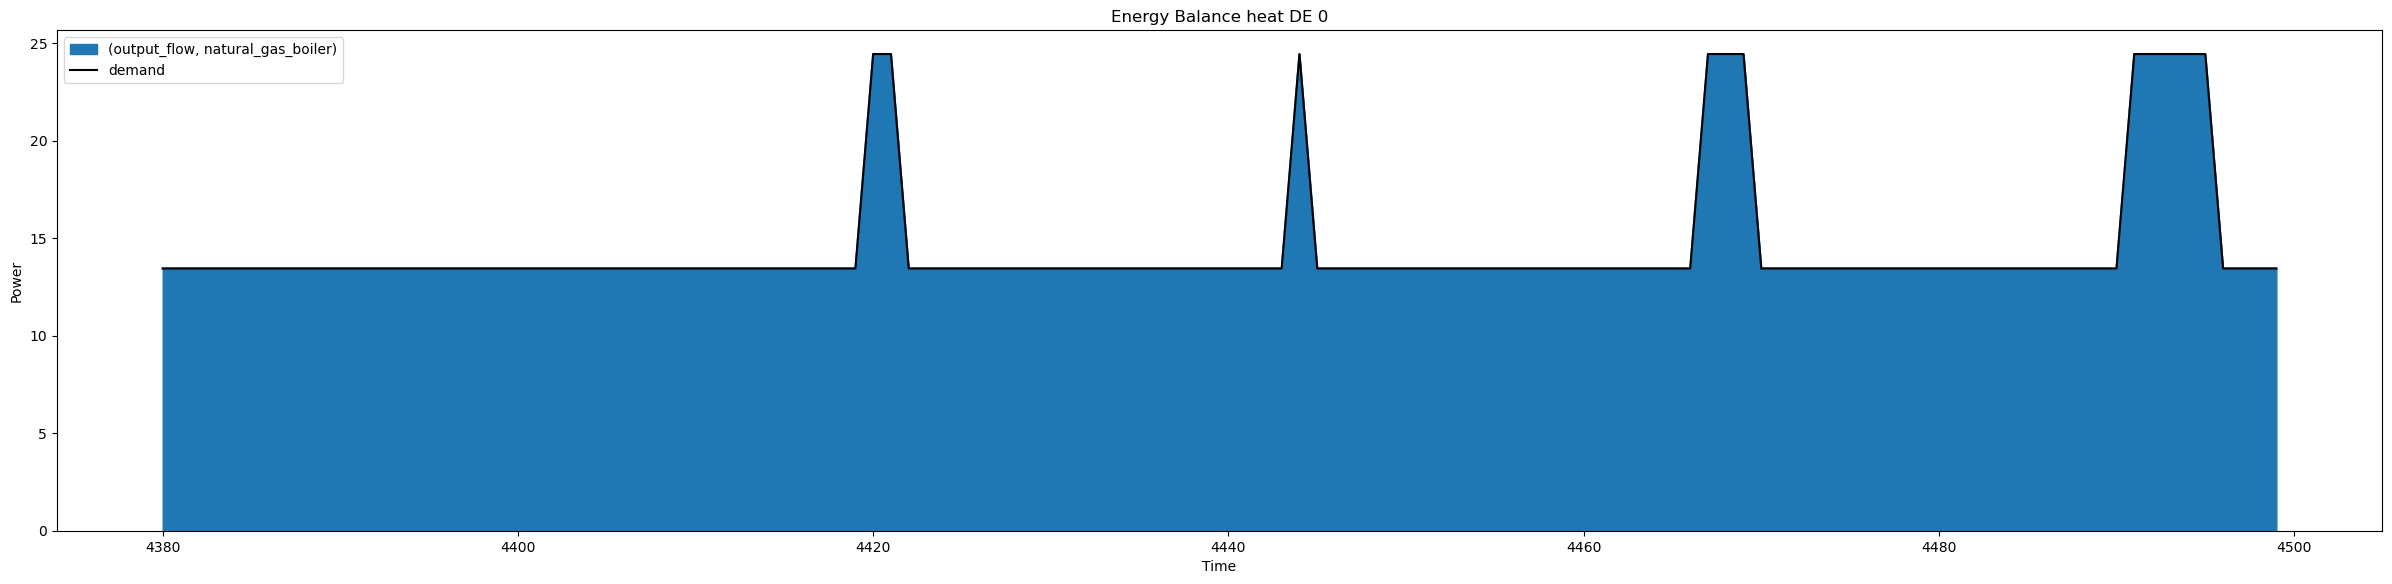

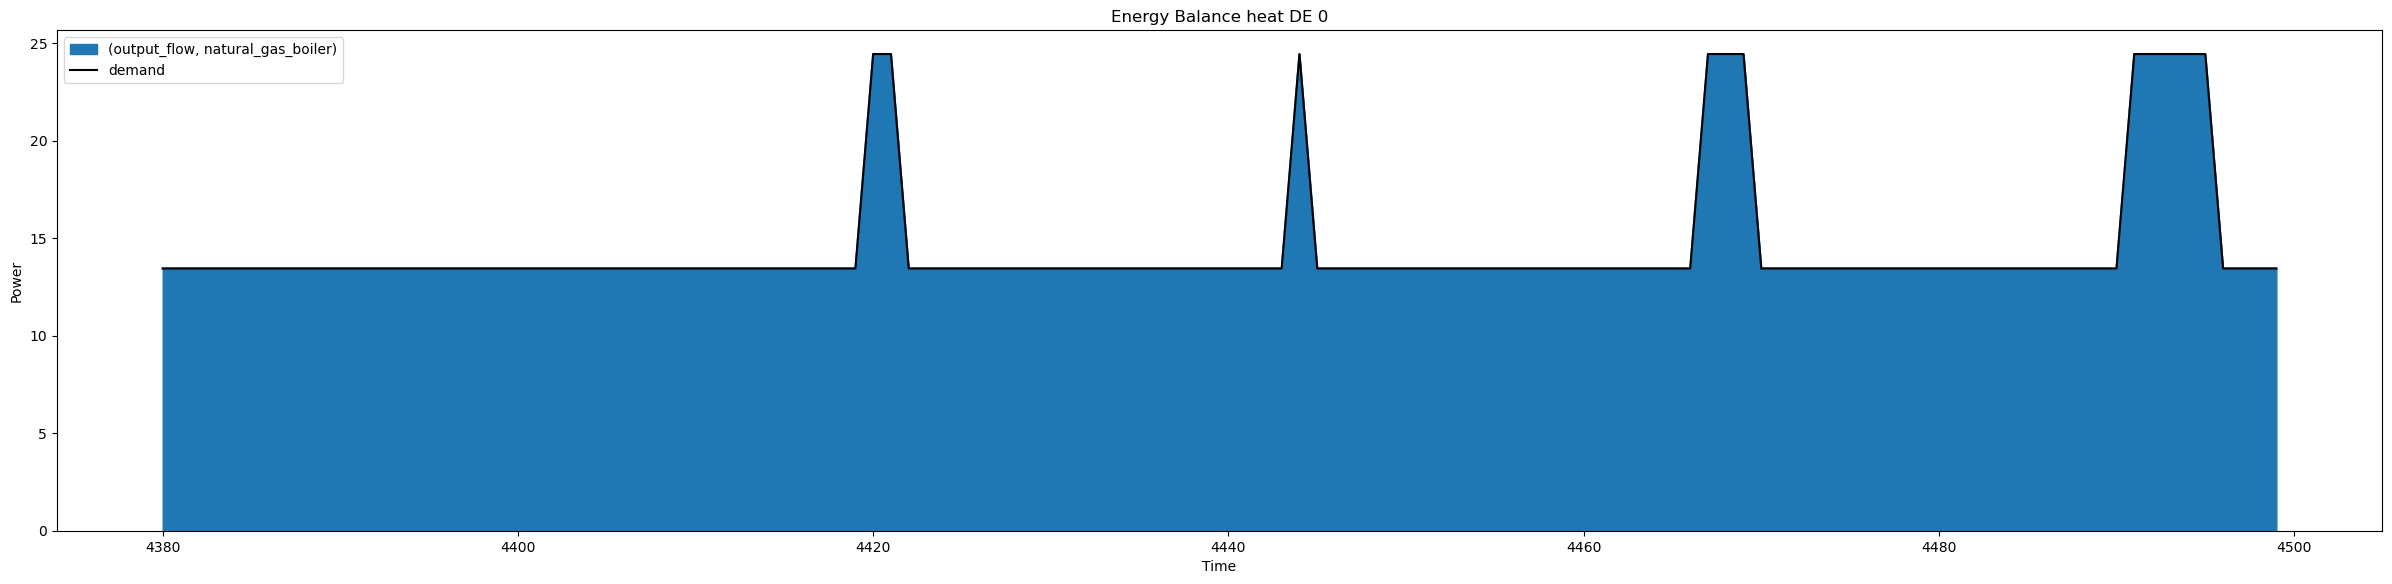

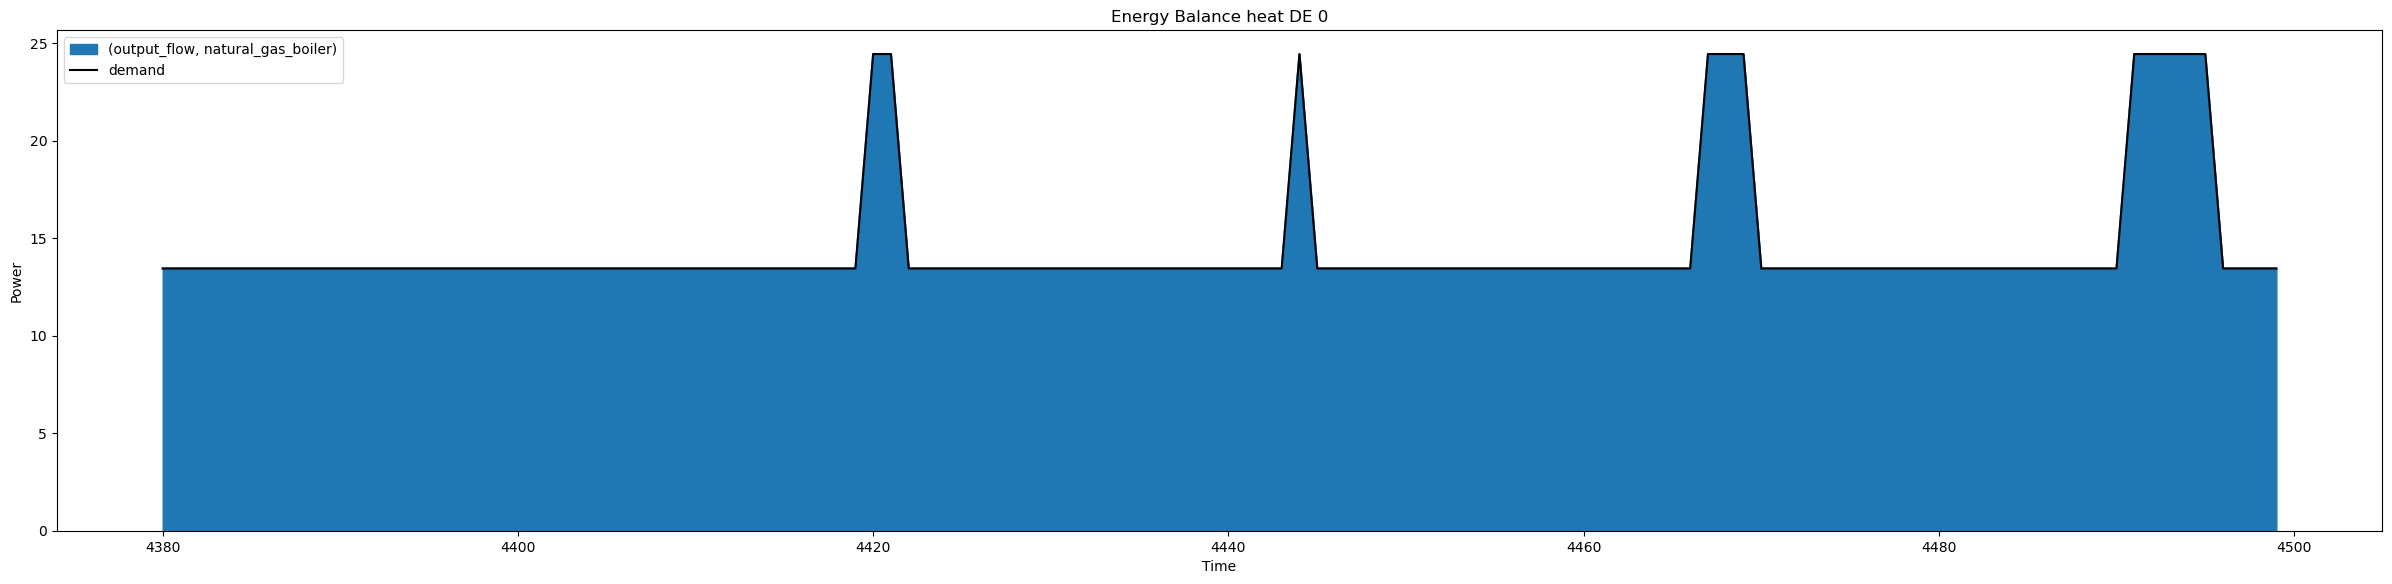

In [4]:
#Visualise the energy balance at the node Germany for the carrier heat in year 0
res_ts.plot_energy_balance("DE","heat",0)
#create a zoom-in
res_ts.plot_energy_balance("DE", "heat", 0, start_hour=int(8760/2), duration=5*24)
#save your figure as a pdf(works identically for all three plot functions)(figure is shown anyway)
res_ts.plot_energy_balance("DE", "heat", 0, start_hour=int(8760/2), duration=5*24, save_fig=True)
#save your figure in another format
res_ts.plot_energy_balance("DE", "heat", 0, start_hour=int(8760/2), duration=5*24, save_fig=True, file_type="png")

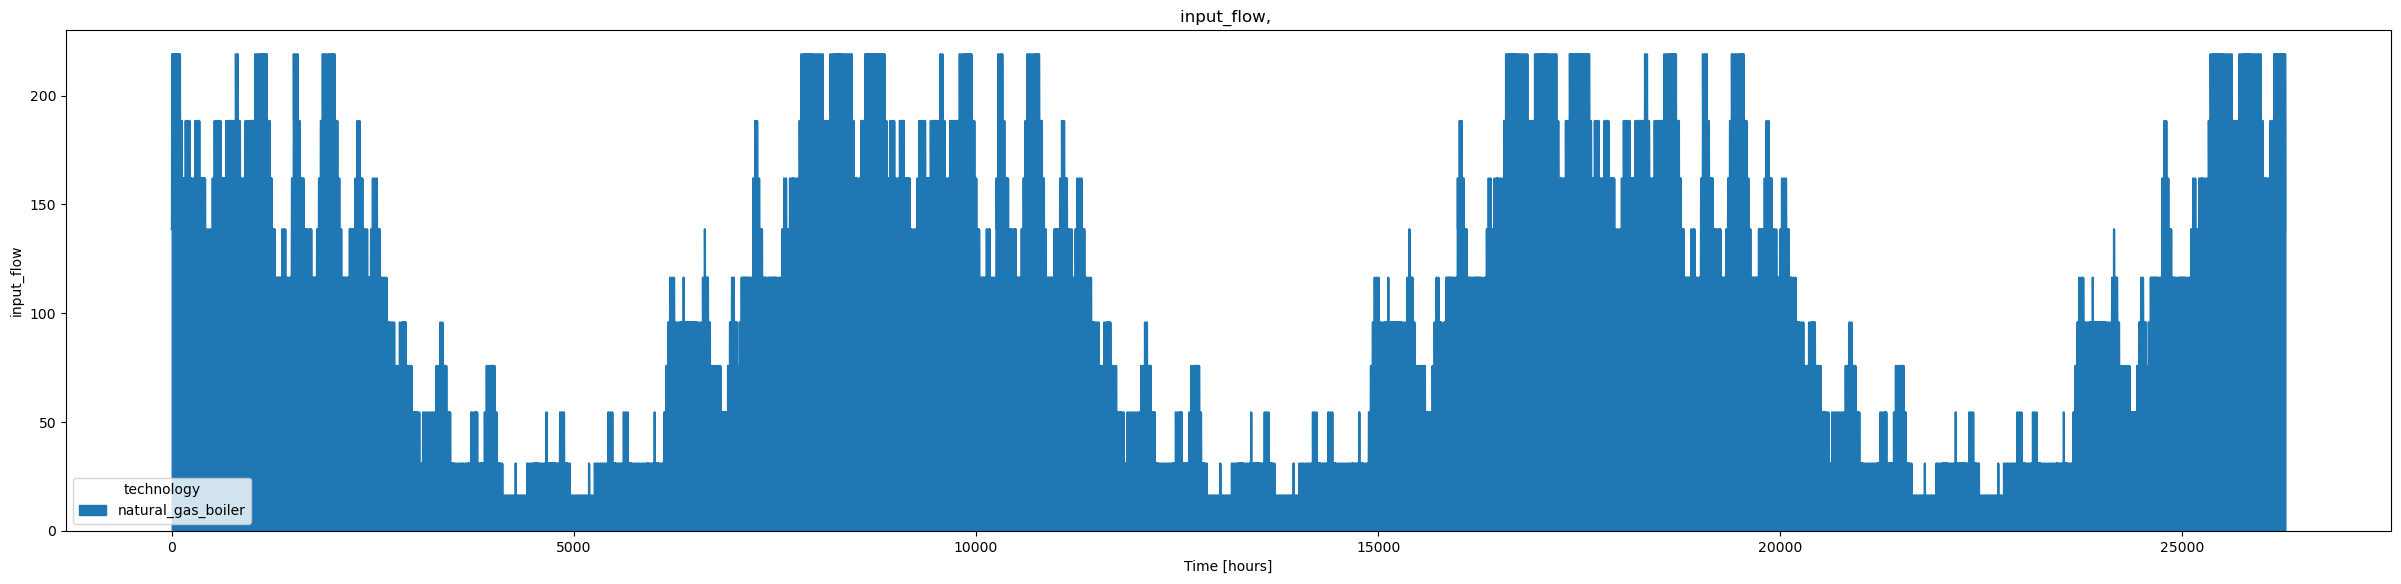

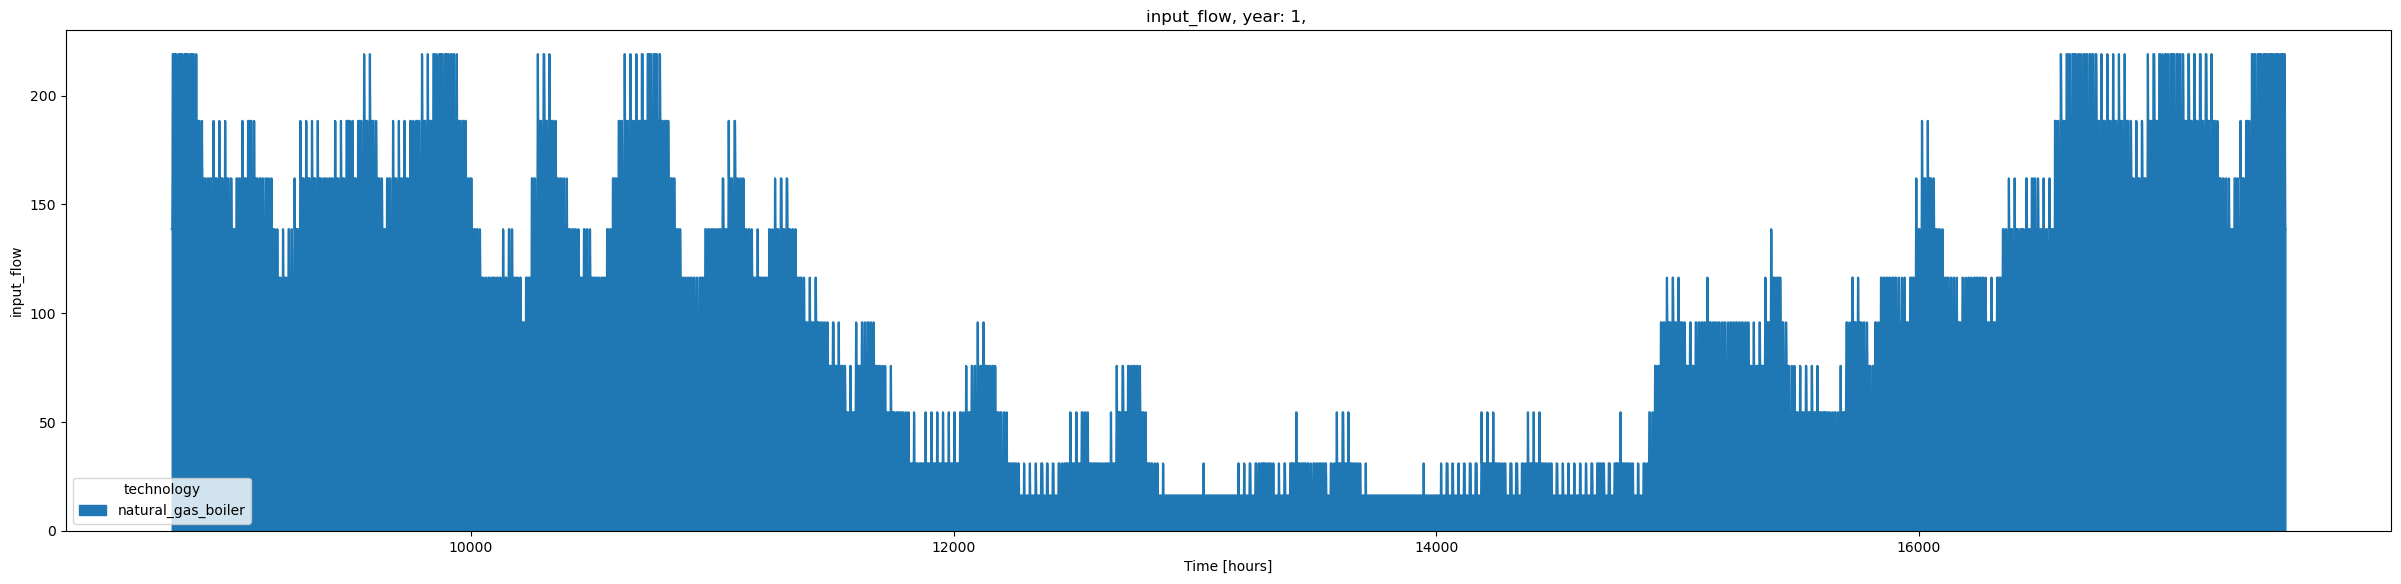

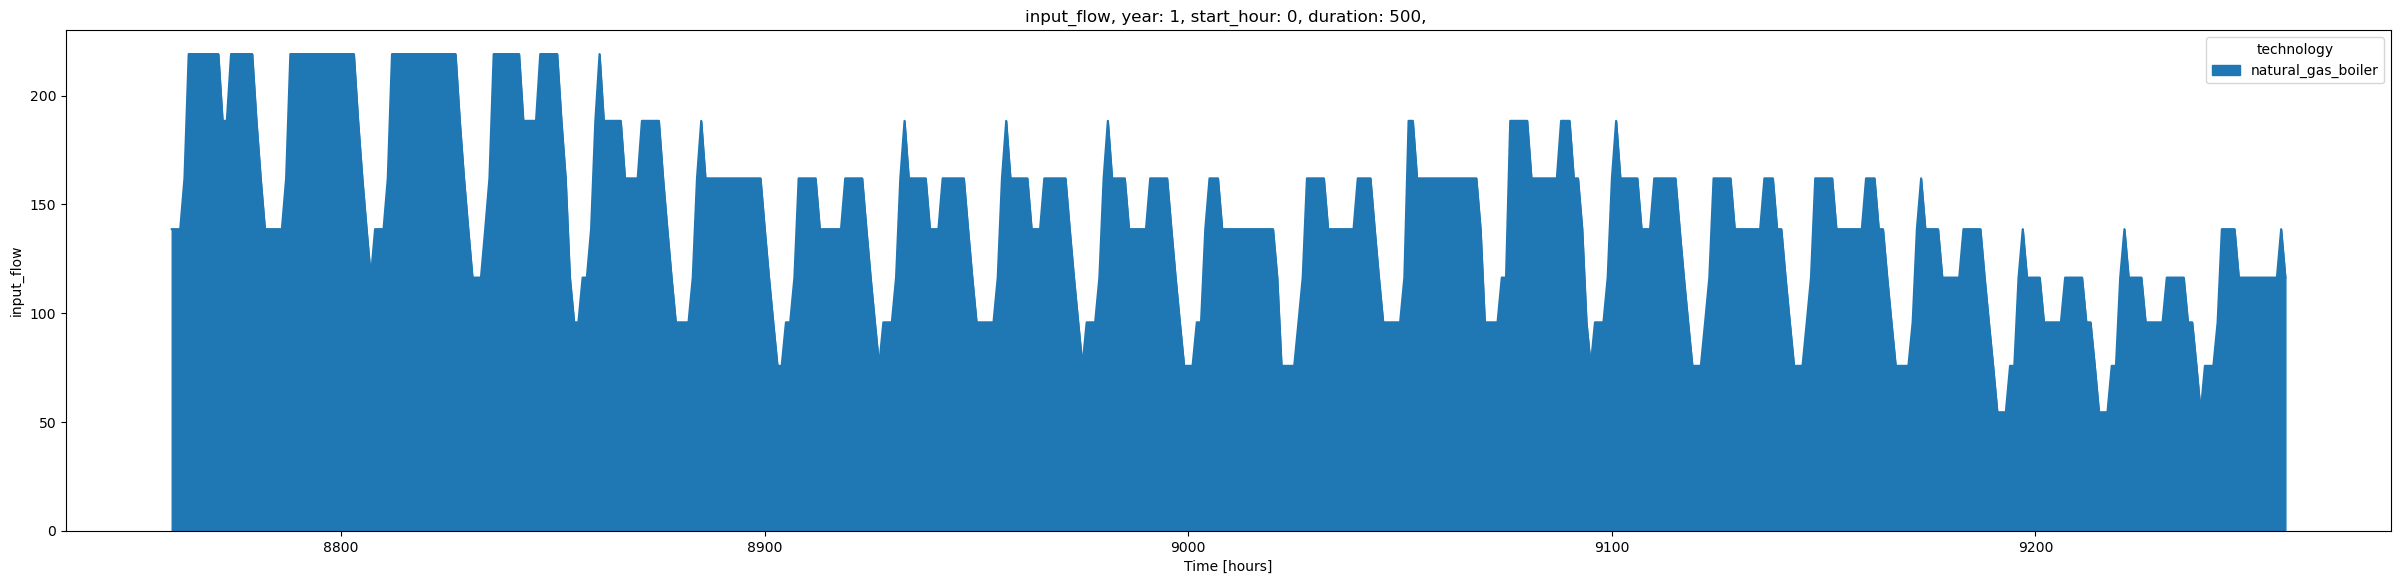

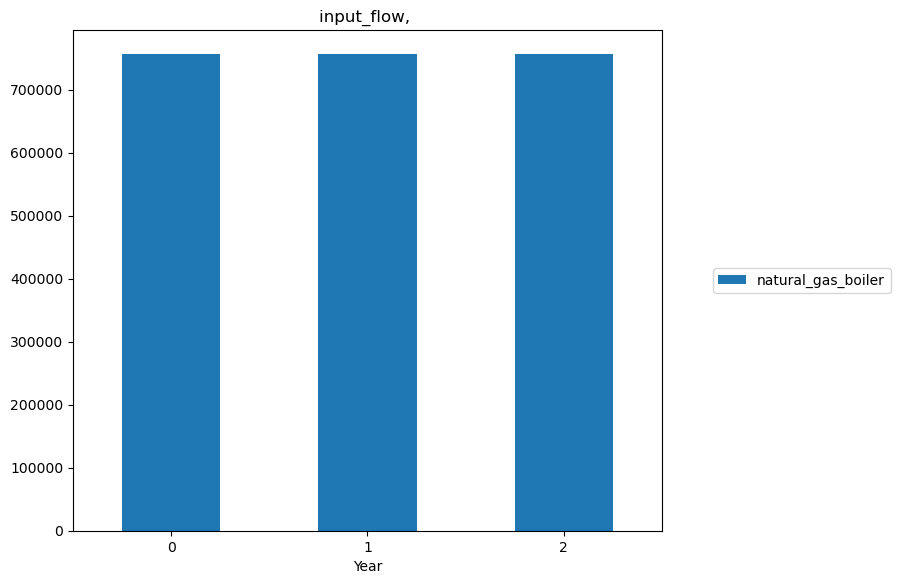

In [5]:
#Create more customized plots:
res_ts.plot("input_flow")
#time adjustments
#plot only second year
res_ts.plot("input_flow", year=1)
#create zoom-in
res_ts.plot("input_flow", year=1, start_hour=0, duration=500)
#use yearly time steps
res_ts.plot("input_flow", yearly=True)

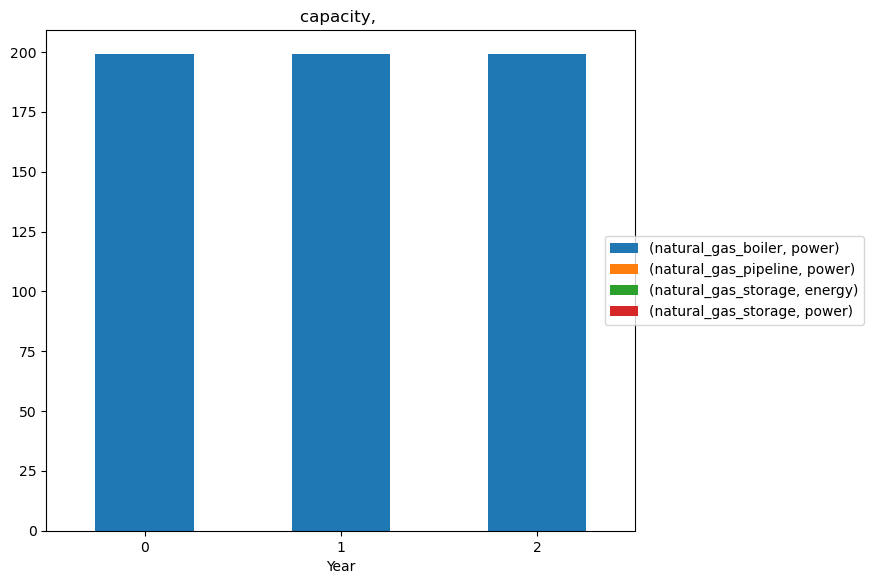

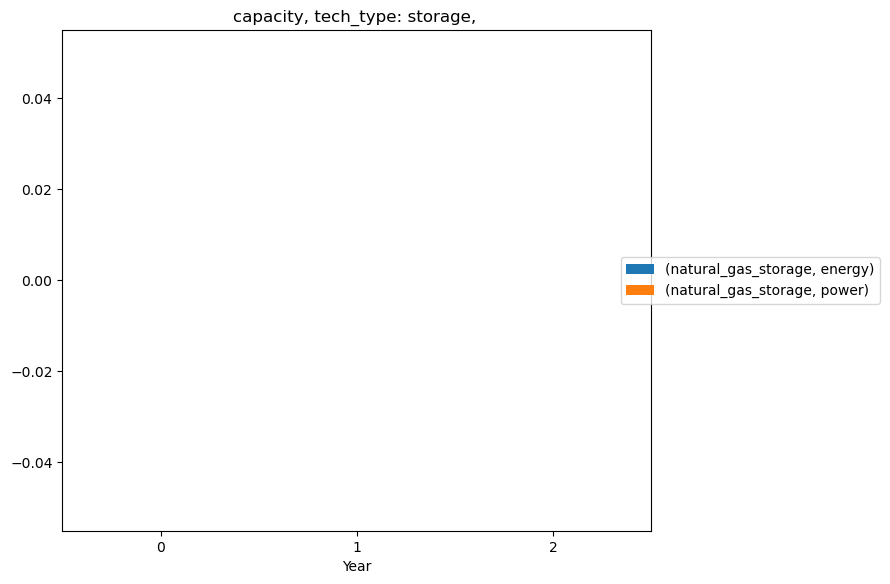

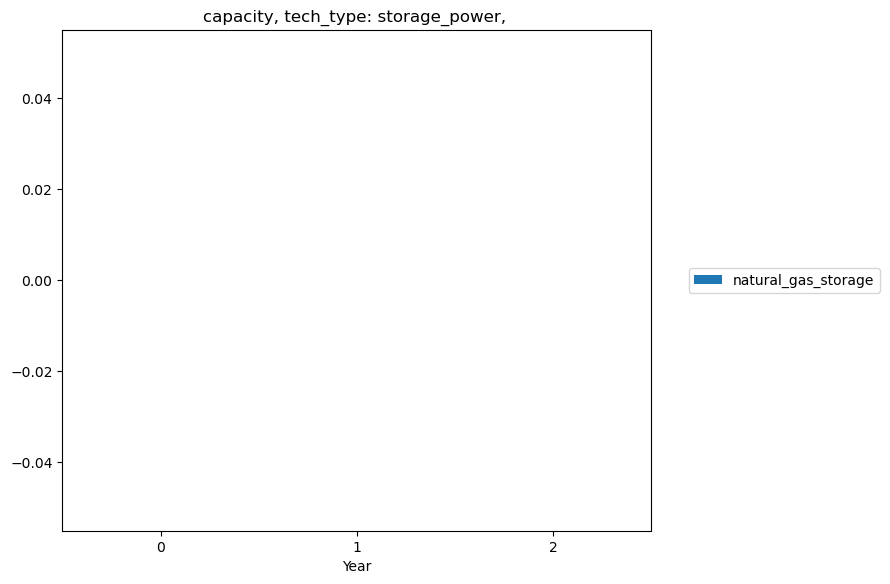

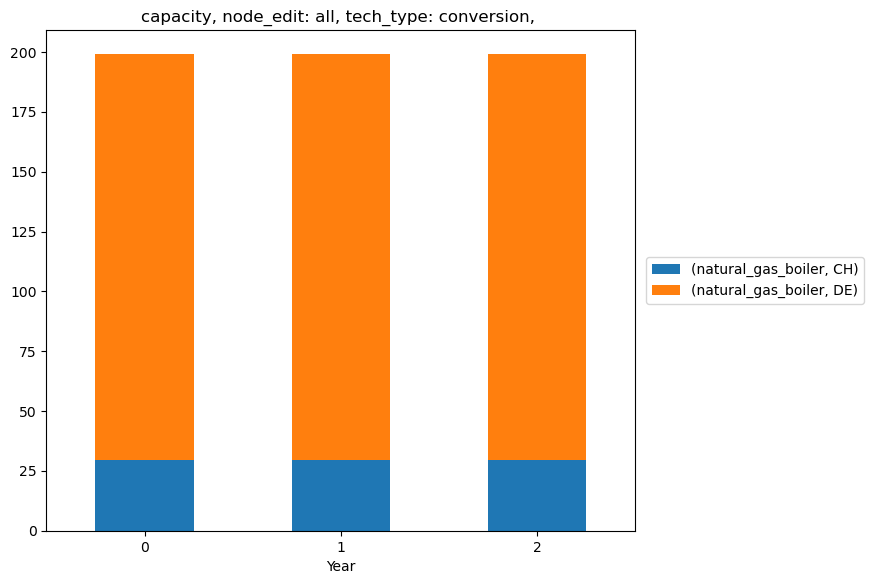

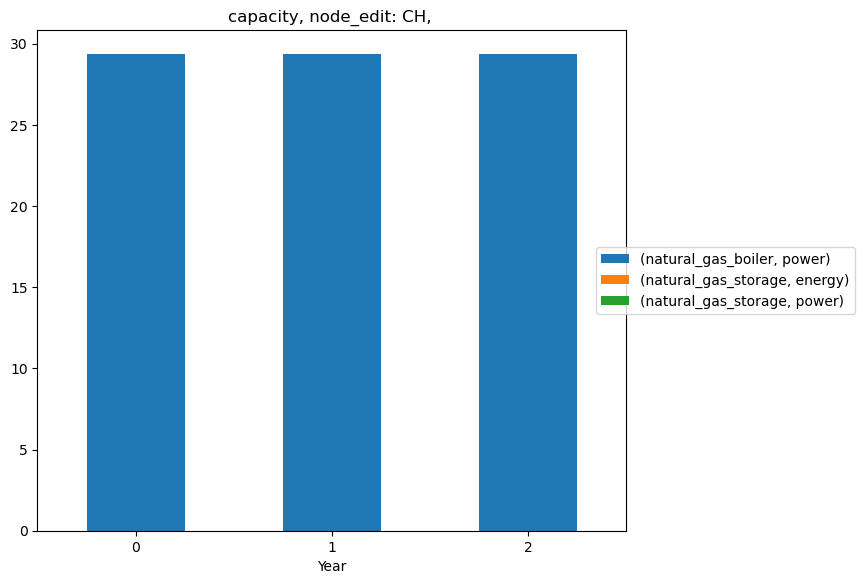

In [6]:
res_ts.plot("capacity")
#data adjustments
#plot specific technology type
res_ts.plot("capacity", tech_type="storage")
#plot charging/discharging capacities
res_ts.plot("capacity", tech_type="storage_power")
#plot all nodes separately
res_ts.plot("capacity", tech_type="conversion", node_edit="all")
#plot data of a single node
res_ts.plot("capacity", node_edit="CH")

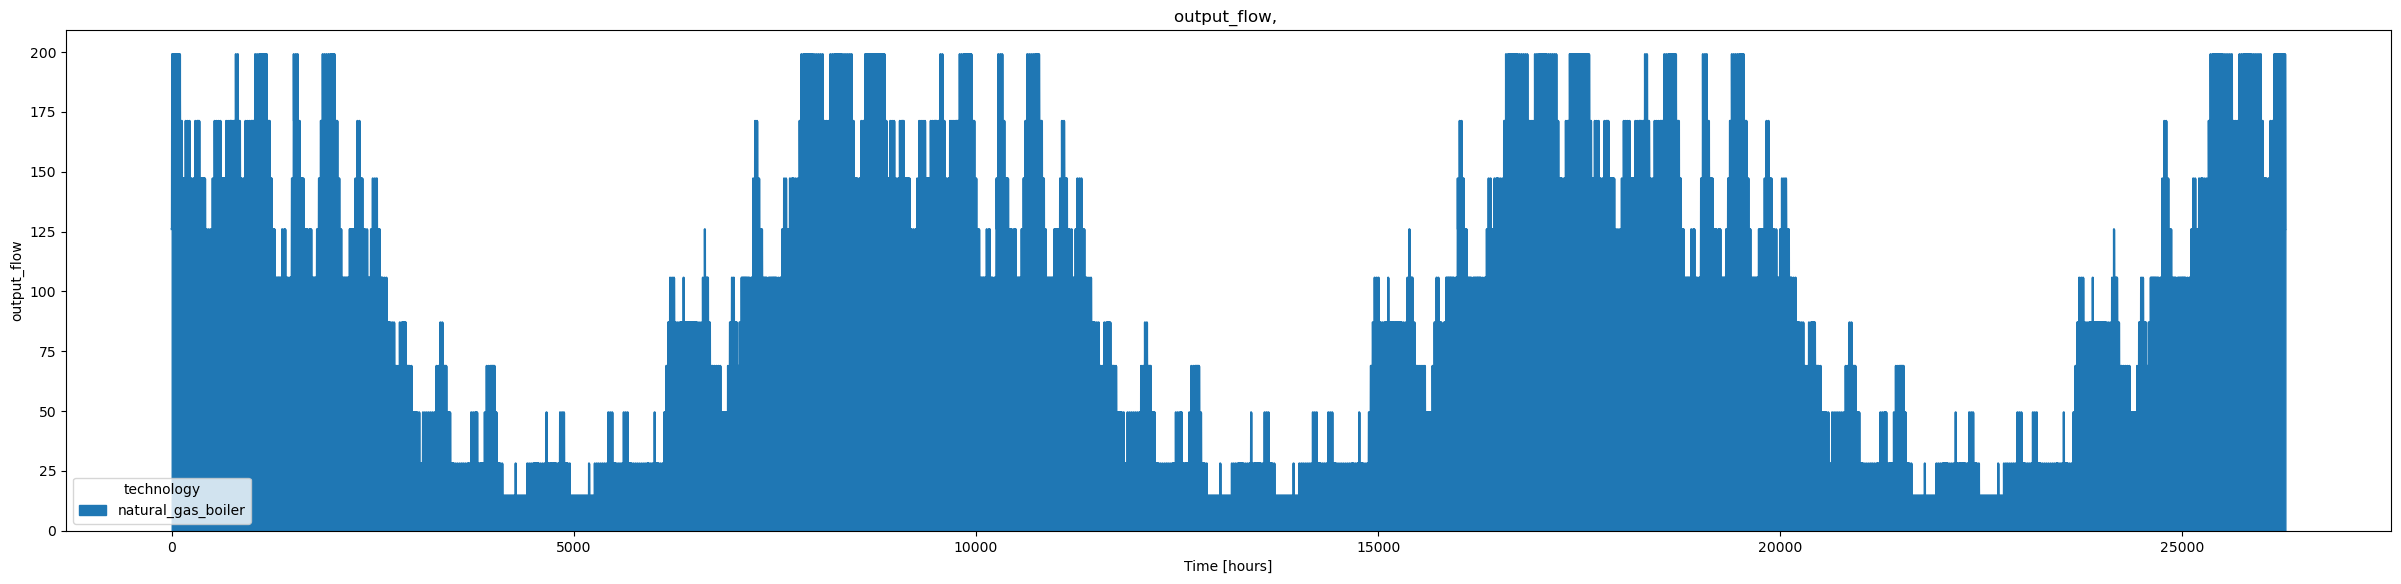

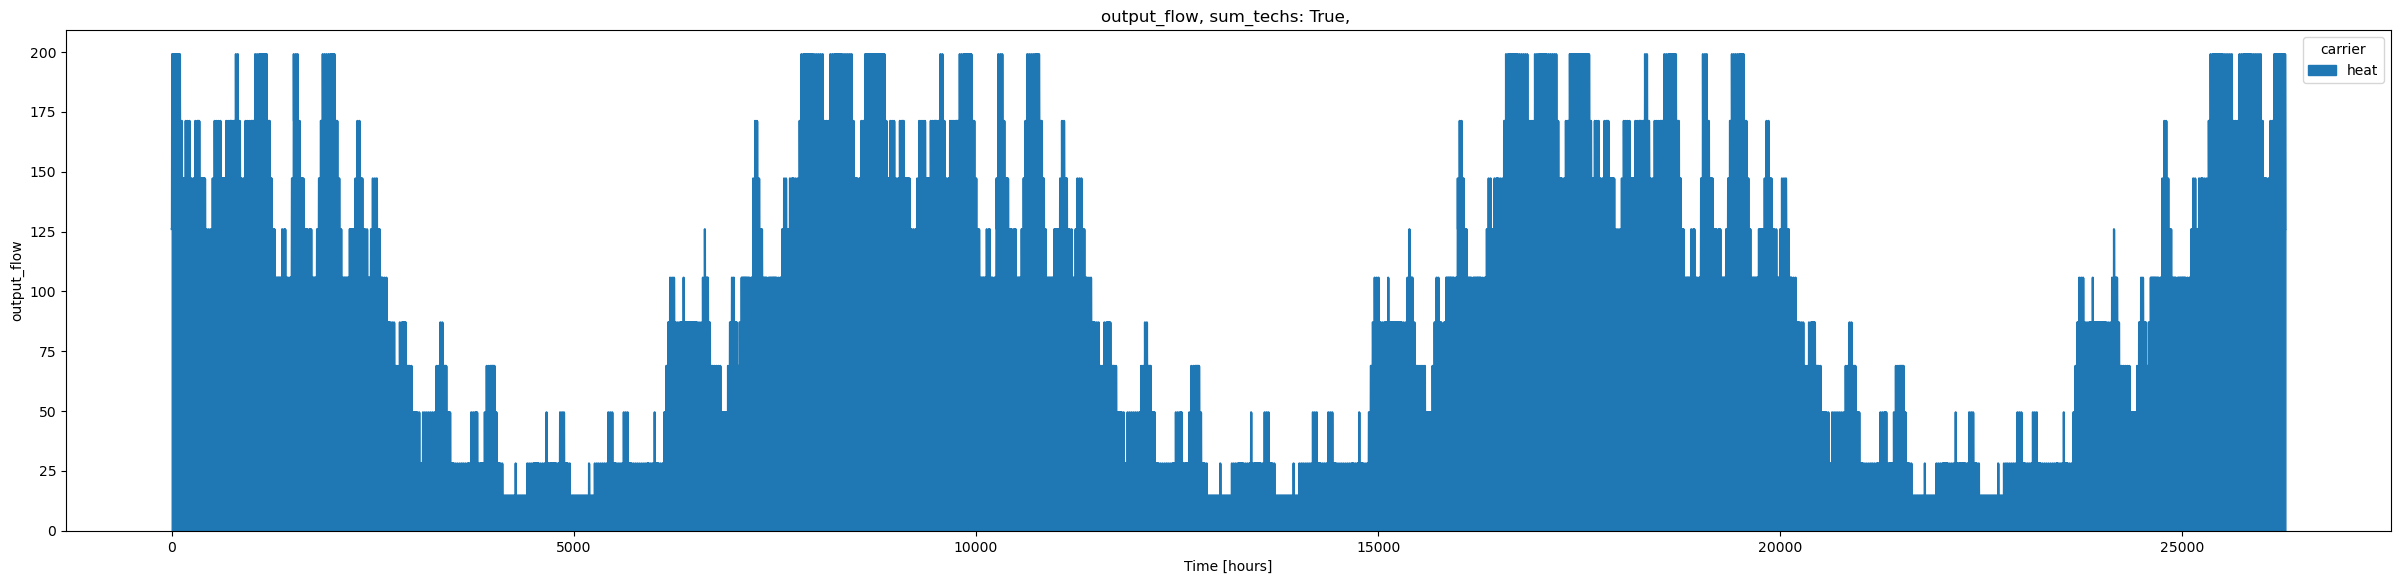

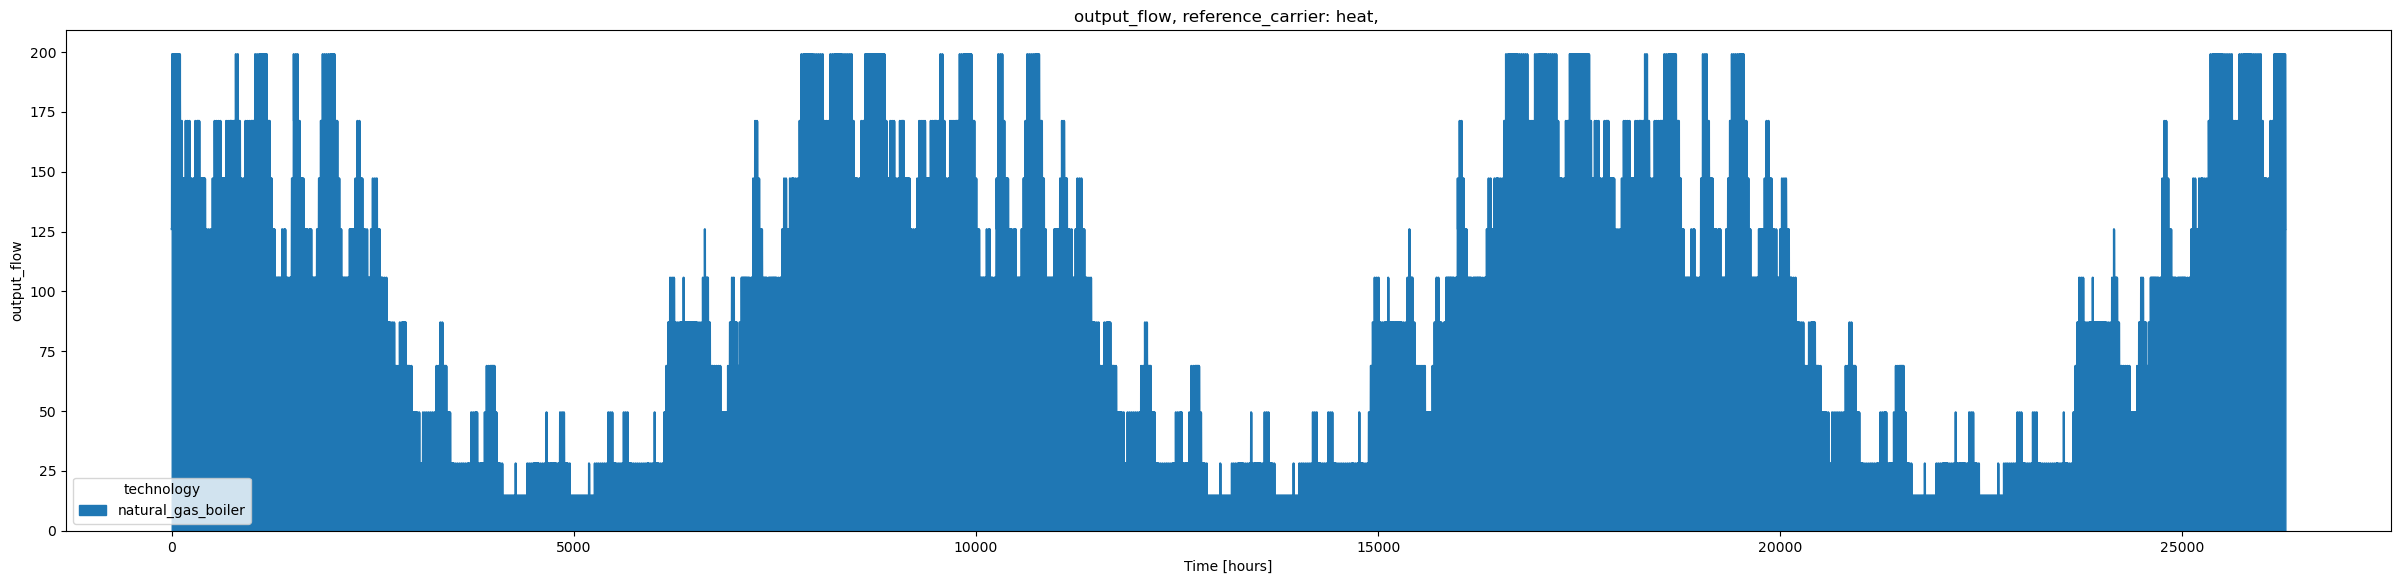

In [7]:
res_ts.plot("output_flow")
#sum technologies of identical output carrier (effect can't really be seen as there is only one tech in the dataset)
res_ts.plot("output_flow", sum_techs=True)
#extract technologies of specific reference carrier (effect can't really be seen as there is only one tech in the dataset)
res_ts.plot("output_flow", reference_carrier="heat")

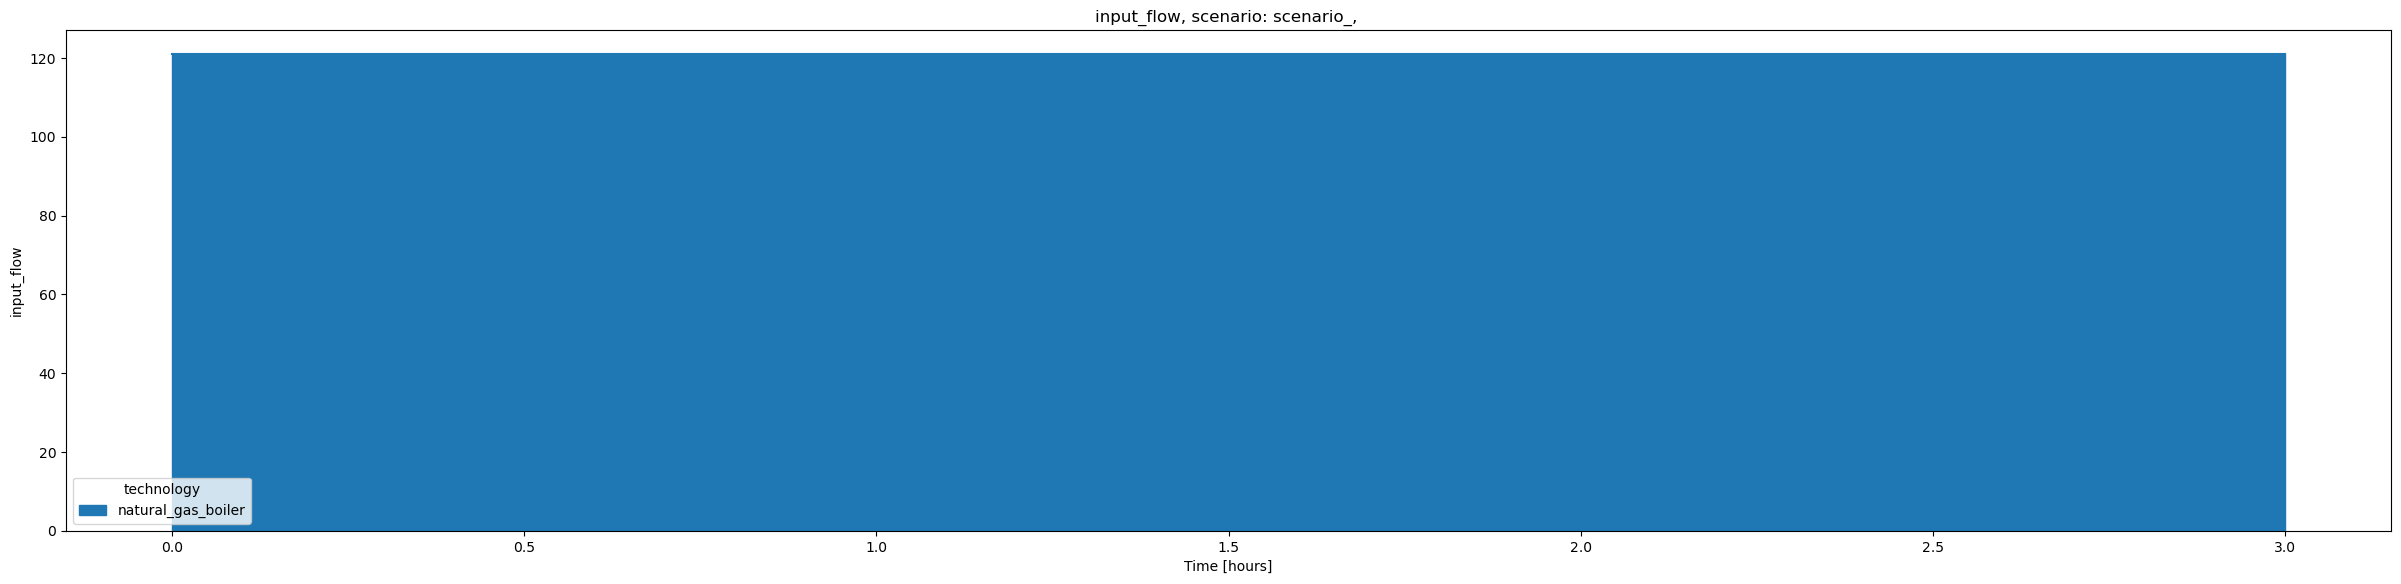

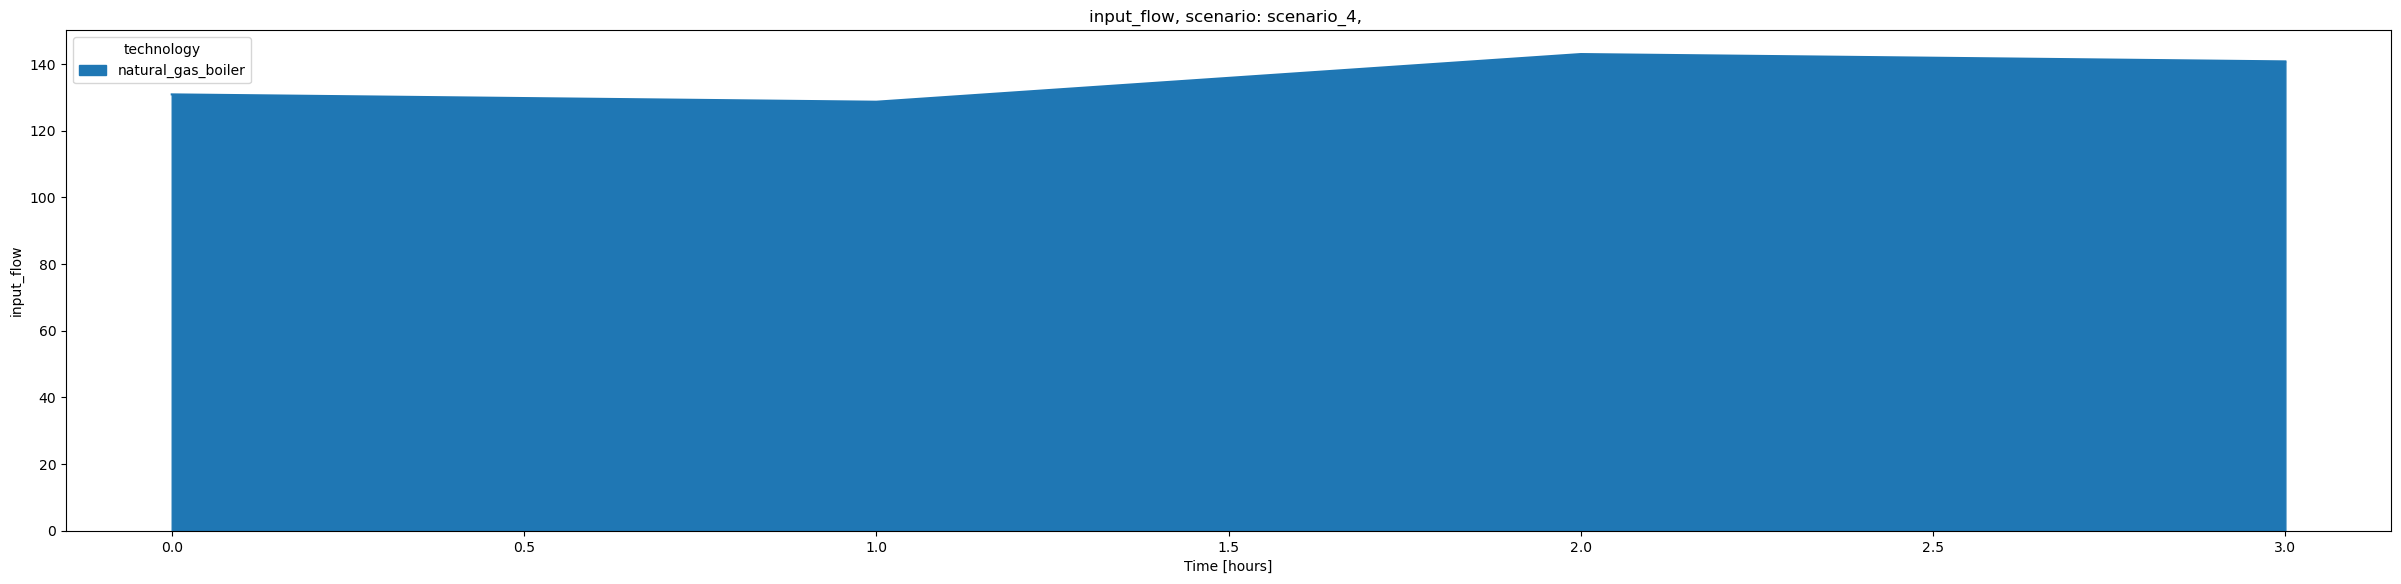

In [8]:
#create plot of multi-scenario dataset (standard scenario is plotted)
res_scenario.plot("input_flow")
#specify another scenario
res_scenario.plot("input_flow", scenario="scenario_4")